# Predicting Kepler Exoplanet Archive Disposition

___

By: Alejandro Garcia
<br>
Date: April 27, 2022

___

## Project Goals

Identify drivers of the exoplanet archive disposition to determine which attributes are most likely to be predictive of the dispositions of confirmed exoplanet or false positive.

___

## Project Description

The Kepler Space Observatory is a NASA-built telescope dedicated to searching for exoplanets in star systems besides our own, with the ultimate goal of possibly finding other habitable planets. The Kepler Space Observatory is retired as of October 30, 2018, but all the data it collected can be accessed from the NASA Exoplanet Archive [here](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=cumulative), or from Kaggle [here](https://www.kaggle.com/datasets/nasa/kepler-exoplanet-search-results). Observations in the Kepler Object of Interest table were made using the transit method for identifying exoplanets in other star systems. The transit method involves measuring the light intensity of a host star over time and looking for periodic dips in light intensity which signify an object eclipsing the host star, which could potentially indicate the presence of an exoplanet.

Identifying exoplanets can be a time consuming process particularly for planets with long orbital periods, such as planets that like the Earth may take upwards of a year to orbit their host star. With that in mind when candidate exoplanets are identified being able to prioritize the candidates that will most likely be confirmed can help to further the goal of identifying exoplanets. So we would like to determine which attributes are most indicative of a confirmed exoplanet disposition and similarly which attributes are most indicative of a false positive disposition. Finally, once these attributes are determined they will be used to produce a reusable machine learning model that can help predict which exoplanet candidates are most likely to be confirmed.

As a data scientist with an interest in astronomy I aim to provide a means for determining which objects of interest will be most likely to result in newly discovered exoplanets. This way time is not lost observing objects that may end up not being exoplanets.

___

## Importing the Required Modules

Everything we need to run the code blocks in this notebook are located in the top level directory. To run the code blocks in this report you will need numpy, pandas, matplotlib, seaborn, and sklearn installed on your computer. You will also need the Kaggle API installed. If you do not have the Kaggle API installed follow the instructions [here](https://github.com/Kaggle/kaggle-api) to install it.

In [1]:
# We would like to ignore any warnings that may be provided by our libraries.

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Here we are importing everything needed to execute the code blocks in this notebook.

from wrangle import wrangle_kepler
from explore import *
from model import *
from preprocessing import scale_data
from evaluate import append_results, evaluate

---

## Data Acquisition and Preparation

The data is acquired from Kaggle using the Kaggle API. This requires an API key. Alternatively, the .csv file can be downloaded manually from Kaggle.

**Missing Values:**
The raw data contains some missing values. A few columns are nearly empty upon loading the raw data. Columns with a large percentage of missing values are dropped. Then any rows still missing values are dropped. This leaves 94% of the original columns and 82% of the observations remaining.

**Removing Observations That Don't Fit the Project Goals:**
The target variable (disposition / koi_disposition) has three unique values: FALSE POSITIVE, CONFIRMED, and CANDIDATE. Any observations with a disposition of CANDIDATE are removed since these observations do not fit into the scope of this project. This leaves 63% of the original observations remaining.

These candidate observations are observations that have been marked as potential exoplanets, but enough analysis to determine the observation as a confirmed exoplanet, or not, has not been conducted. The final target value of an observation is either CONFIRMED, meaning the observation was in fact an exoplanet, or FALSE POSITIVE, meaning the observation was not an exoplanet. This project is only concerned with observations that have been given their final target value so the candidate observations are of no concern to us.

**Renaming Columns:**
Lastly, a few of the columns are renamed for readability. Only those columns that we move forward into modeling with are renamed since there are initially a large number of columns.

In [3]:
# All the code needed to acquire and prepare the data is abstracted into a wrangle function for ease of use.
# For details on how the data is acquired and prepared refer to the acquire.py and prepare.py files or the 
# wrangle.ipynb notebook.

# Here we will acquire, prepare, and split the data.

train, validate, test = wrangle_kepler()

# We will need scaled data in modeling so here we will scale the data.

train_scaled, validate_scaled, test_scaled = scale_data(
    train,
    validate,
    test,
    train.drop(columns = 'disposition').columns
)

---

## Exploratory Analysis

With the data prepared we can begin exploring the data to identify which attributes are most closely related to the exoplanet archive disposition

In the visualizations below we aim to answer some questions about the data. Details about how these visualization are created can be found in the explore.py file.

**Important Note:**
Some features in the data were discovered to leak information about the exoplanet disposition. These assumptions were verified in exploration and the details can be found in the explore.ipynb notebook. These features were not used in further exploration or modeling in order to ensure that the models produced are robust to newly obtained observations.

### Is there a significant difference in orbital period between false positives and confirmed exoplanets?

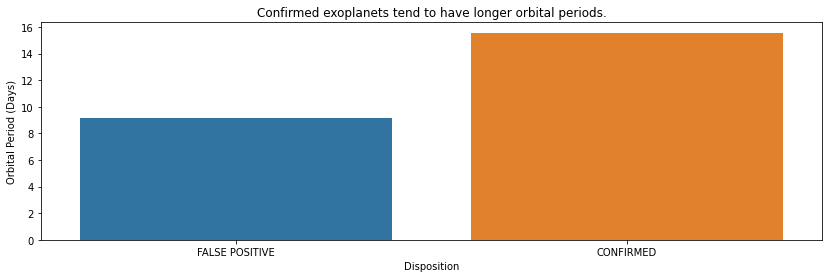

In [4]:
# Here we will plot the average orbital periods for false positive observations and confirmed exoplanet observations.
# Details can be found in explore.py.

plot_orbital_period(train)

We see here that confirmed exoplanets on average have longer orbital periods than false positive observations. My best guess is that this is due to binary star systems, which do often orbit very rapidly, being falsely identified as candidate exoplanets.

Let's now confirm this finding with a statistical test. Here we will perform a two sample t-test where the two samples are false positive observations and confirmed exoplanet observations. We will test to determine if the average orbital period between the two groups is significantly different. The hypothesis we'll be testing is the following:

$H_0$: The average orbital period for false positives is equal to the average orbital period for confirmed exoplanets.
<br>
$H_a$: The average orbital period for false positives is not equal to the average orbital period for confirmed exoplanets.

In [5]:
# Here we conduct a two sample t-test between the orbital period for each sample.
# Details can be found in explore.py or explore.ipynb.

# We'll be using these masks to separate the false positives and confirmed exoplanets for all stats tests
# going forward.

false_positives = train.disposition == 'FALSE POSITIVE'
confirmed = train.disposition == 'CONFIRMED'

two_sample_ttest(train[false_positives], train[confirmed], feature = 'orbital_period')

Reject H0


The result is that we reject the null hypothesis indicating that there is a significant difference in orbital period between false positive observations and confirmed exoplanets.

### Do observations with a false positive disposition have a greater planetary radius than confirmed exoplanets?

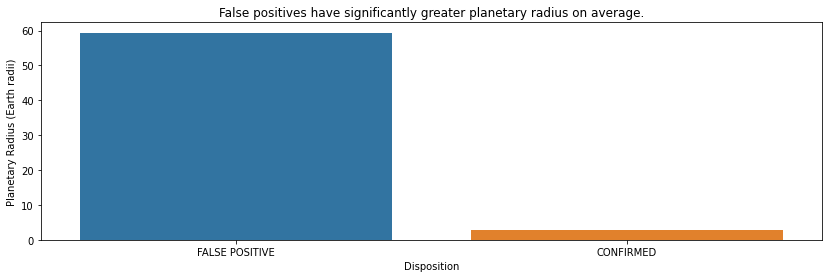

In [6]:
# Here we will plot the average planetary radius for false positive observations and confirmed exoplanet observations.
# Details can be found in explore.py.

plot_planetary_radius(train)

We see here that the average planetary radius for false positive observations is significantly greater than that of confirmed exoplanets. This is almost certainly because larger objects will be some type of star.

Let's now confirm this finding with a statistical test. Here we will perform a two sample t-test where the two samples are false positive observations and confirmed exoplanet observations. We will test to determine if the average planetary radius for false positives is significantly greater than that of confirmed exoplanets. The hypothesis we'll be testing is the following:

$H_0$: The average planetary radius for false positives is equal to the average planetary radius for confirmed exoplanets.
<br>
$H_a$: The average planetary radius for false positives is greater than the average planetary radius for confirmed exoplanets.

In [7]:
# Here we conduct a two sample t-test between the planetary radius for each sample.
# We'll use the alternative 'greater' to perform a one tailed test to determine if the average planetary radius 
# for the first sample is significantly greater than the average planetary radius for the second sample.
# Details can be found in explore.py or explore.ipynb.

two_sample_ttest(train[false_positives], train[confirmed], feature = 'planetary_radius', alternative = 'greater')

Reject H0


The result is that we reject the null hypothesis indicating that the average planetary radius for false positives is significantly greater than the average planetary radius for confirmed exoplanets.

### Do observations with a false positive disposition have greater transit depth than confirmed exoplanets?

Transit depth refers to the fraction of stellar flux lost at the minimum of planetary transit. In other words when the object of interest transits the observed star how much does the light intensity decrease.

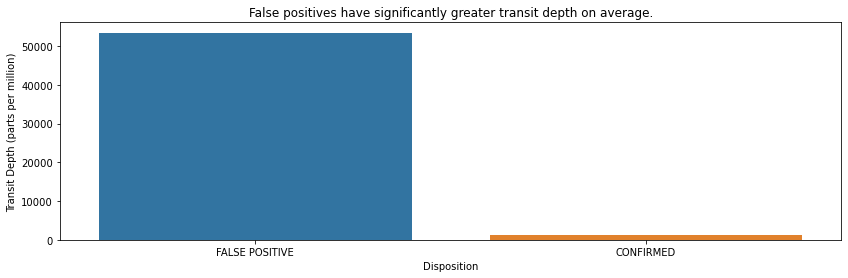

In [8]:
# Here we will plot the average transit depth for false positive observations and confirmed exoplanet observations.
# Details can be found in explore.py.

plot_transit_depth(train)

This is related to the planetary radius. The larger a transiting object is the more stellar flux will be lost.

Let's now confirm this finding with a statistical test. Here we will perform a two sample t-test where the two samples are false positive observations and confirmed exoplanet observations. We will test to determine if the average transit depth for false positives is significantly greater than that of confirmed exoplanets. The hypothesis we'll be testing is the following:

$H_0$: The average transit depth for false positives is equal to the average transit depth for confirmed exoplanets.
<br>
$H_a$: The average transit depth for false positives is greater than the average transit depth for confirmed exoplanets.

In [9]:
# Here we conduct a two sample t-test between the transit depth for each sample.
# We'll use the alternative 'greater' to perform a one tailed test to determine if the average transit depth 
# for the first sample is significantly greater than the average transit depth for the second sample.
# Details can be found in explore.py or explore.ipynb.

two_sample_ttest(train[false_positives], train[confirmed], feature = 'transit_depth', alternative = 'greater')

Reject H0


The result is that we reject the null hypothesis indicating that the average transit depth for false positives is significantly greater than the average transit depth for confirmed exoplanets.

### Is there a significant difference in transit duration between false positives and confirmed exoplanets?

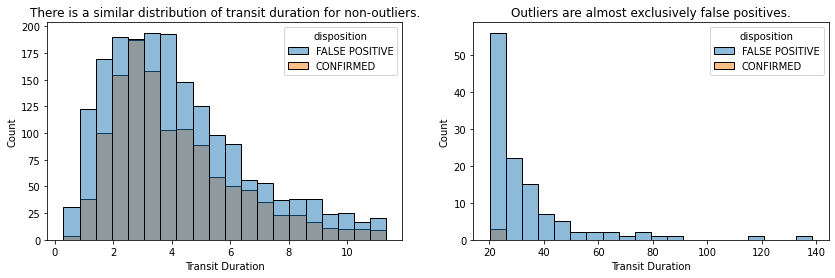

In [10]:
# Here we will plot the distributions of transit duration for false positives and confirmed exoplanets.
# On the left is a chart that contains the distributions with outliers removed. On the right is a chart 
# that contains the distributions for only outliers.
# Details can be found in explore.py.

plot_transit_duration(train)

The transit duration could be related to planetary radius. The larger an object is the longer it takes to transit the host star. However, it could also be related to orbital period. The further away from the host star an object is the longer it will take to transit. In either case we can see that there may be some difference in transit duration between false positive observations and confirmed exoplanet observations.

We can test if there is a significant different with a statistical test. Here we will perform a two sample t-test where the two samples are false positive observations and confirmed exoplanet observations. We will test to determine if the average transit duration between the two groups is significantly different. The hypothesis we'll be testing is the following:

$H_0$: The average transit duration for false positives is equal to the average transit duration for confirmed exoplanets.
<br>
$H_a$: The average transit duration for false positives is not equal to the average transit duration for confirmed exoplanets.

In [11]:
# Here we conduct a two sample t-test between the orbital period for each sample.
# Details can be found in explore.py or explore.ipynb.

two_sample_ttest(train[false_positives], train[confirmed], feature = 'transit_duration')

Reject H0


The result is that we reject the null hypothesis indicating that there is a significant difference in transit duration between false positive observations and confirmed exoplanets.

### Exploration Takeaways and Summary

The features orbital period, planetary radius, transit depth, and transit duration all showed significant distinctions between false positives and confirmed exoplanets when plotted against the target variable. Additionally, the features normalized depth and approximate planetary temperature also showed significant distinctions between false positives and confirmed exoplanets, but are not shown here (details on these two features can be found in explore.ipynb). All statistics tests executed confirmed that there were significant differences in values between the two groups for each feature. For this reason we move forward into modeling with these features.

These weren't the only features analyzed. Many other features were analyzed and discovered to not have significant distinctions between the two groups being analyzed. Also some features were discovered to leak information about the target and for this reason could be used in further exploration or modeling.

There is further analysis that can be done. For instance, it was also discovered that there may be distinct groups when looking at features such as transit duration, orbital period, and transit depth. There wasn't enough time to look more deeply into these insights, but it's something to look into given more time to analyze the data.

---

## Modeling

In the modeling phase many different models were created to find the best model to predict the exoplanet disposition. Various machine learning algorithms were used with a variety of hyper-parameters. Also different numbers of features were used to determine if the number of features would change the performance of a model. In total 158 different models were produced and evaluated. For brevity, below we'll show only a few of the best performers.

In this project we primarily use accuracy to measure the performance of our models since there is a fairly even split between false positives and confirmed exoplanets. In the case when two models have similar accuracy the precision score will help break the tie since we want to be sure of our positive predictions. When an observation is predicted as a confirmed exoplanet this would reasonably lead to prioritizing analysis of that object to verify the prediction. We want to be sure that this time spent analyzing an object will not be for nothing.

Additionally, since we are interested primarily in identifying confirmed exoplanets more than false positive dispositions, the disposition of CONFIRMED will be our positive label.

### Establishing a Baseline

First a baseline model must be established. This model will be used to compare with the models we produce. This is the simplest model we can create which will simply predict the most common value of the target variable.

In [12]:
# Here we'll establish the baseline model and evaluate its performance.

evaluate_dataframe = establish_baseline(train, validate, target = 'disposition')
evaluate_dataframe

,train_accuracy,train_recall,train_precision,validate_accuracy,validate_recall,validate_precision
Baseline,0.62,0.0,0.0,0.62,0.0,0.0


### Create Some Models

Now with a baseline model established we can create some models. As mentioned before, here we'll only produce a few of the models that were produced when going through this project.

In [13]:
# Here we'll produce four different models, a decision tree, and three variations of a gradient boosting 
# classifier. The first gradient boosting varient uses hyper-parameters loss equals exponential and 
# n_estimators equals 300 with the features orbital period and planetary radius. The second variant uses 
# the same hyper-parameters with the features orbital period, planetary radius, normalized depth, transit 
# depth, and transit duration. The other two model use default hyper-parameters with the features orbital 
# period and planetary radius.

# We also need to use the scaled data here.

models = create_and_train_models(train_scaled, target = 'disposition')

In [14]:
# Now we'll evaluate the models on train and validate.
# Again we need the scaled data.

for name, model in models.items():
    evaluate_dataframe = evaluate_model(model, name, train_scaled, validate_scaled, 'disposition', evaluate_dataframe)
    
# We want to see the results sorted descending by validate accuracy. We're interested in seeing how the 
# models perform on unseen data.
    
evaluate_dataframe.sort_values(by = 'validate_accuracy', ascending = False)

,train_accuracy,train_recall,train_precision,validate_accuracy,validate_recall,validate_precision
Gradient Boosting Variant 2,0.95,0.95,0.92,0.90,0.88,0.85
Gradient Boosting Classifier,0.87,0.87,0.80,0.84,0.81,0.78
Gradient Boosting Variant 1,0.90,0.90,0.84,0.84,0.80,0.79
Decision Tree,0.84,0.90,0.74,0.83,0.88,0.73
Baseline,0.62,0.00,0.00,0.62,0.00,0.00


The gradient boosting classifier with hyper-parameters loss equals "exponential" and n_estimators = 300, with features orbital period, planetary radius, normalized depth, transit depth, and transit duration, had the best performance on unseen data for both accuracy and precision. Let's now evaluate this model on the test dataset.

In [17]:
# Here we'll evaluate the best model on the test dataset. We'll use the scaled data again.

append_results(
    'Gradient Boosting Variant 2',
    evaluate(
        target = test_scaled.disposition,
        prediction = models['Gradient Boosting Variant 2'].make_predictions(test_scaled),
        positive_label = 'CONFIRMED',
        prefix = 'test_'
    )
)

,test_accuracy,test_recall,test_precision
Gradient Boosting Variant 2,0.89,0.89,0.82


The best model has nearly 90% percent accuracy on unseen with just a small drop off in performance compared to the train dataset accuracy meaning the model is not overfit.

## Key Takeaways and Conclusion

After producing a large variety of models for predicting the exoplanet archive disposition of an observed object of interest, or in other words predicting whether or not a transiting object is likely to be an exoplanet, I was able to produce a model that could accurately predict disposition on unseen data with nearly 90% accuracy. Reaching this goal involved analyzing the Kepler Exoplanet Archive data to determine which attributes are most closely related to the disposition.

Several features, such as orbital period, planetary radius, normalized depth, transit depth, transit duration, and temperature, were discovered to be significant for predicting whether an observation is a false positive or a confirmed exoplanet. Statistical tests confirmed that there were significant differences in these values between the two groups in the data.

Some features in the data were discovered to leak information about disposition. These features were avoided in further exploration and modeling in order to ensure that the models produced would be robust to newly obtained observations.

This model could be used as a means of prioritizing which Kepler observations would be most likely to be confirmed exoplanets upon further observation. 

## Next Steps

Given more time I would like to analyze additional features in the data. For some features, such as planet number, I originally determined it would not be useful to explore, but realized later that I may have been wrong in that assumption. Additionally, I would like to more deeply analyze other features I determined as not being useful to the project goals. For instance, I determined many features, such as errors in measurements, would not be useful, but I would like to take the time to verify this analytically.

I also believe that there is great potential in imputing missing values, or otherwise keeping observations that were dropped in preparation, in order to have more observations to analyze.

Many models were produced, but I believe there is opportunity to produce different varieties of models, that were not pursued initially, that could potentially provide better results. I also did not have an opportunity to try training the models with outliers removed which is another strategy that could be pursued.

Finally, with more time I would do further research into the data and how it is collected in order to ensure that work done here would in fact be robust to newly obtained observations. There are also many features that are available through the NASA API that could potentially provide more insights into the exoplanet data.